In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

In [2]:
N_FEATURES = 3
N_TIME_STEPS = 200
N_CLASSES = 6
N_HIDDEN_UNITS = 64

N_EPOCHS = 100
BATCH_SIZE = 1024
LEARNING_RATE = 0.0025
L2_LOSS = 0.0015

RANDOM_SEED = 42

LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

# Loading the data

In [3]:
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv('WISDM_ar_v1.1_raw.txt', header = None, names = columns)
df = df.dropna()

In [4]:
df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098203 entries, 0 to 1098203
Data columns (total 6 columns):
user         1098203 non-null int64
activity     1098203 non-null object
timestamp    1098203 non-null int64
x-axis       1098203 non-null float64
y-axis       1098203 non-null float64
z-axis       1098203 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


In [6]:
def normalize(df, column):
    data = df[column]
    mu = np.mean(data, axis = 0)
    sigma = np.std(data, axis = 0)
    return (data - mu) / sigma

df['x-axis'] = normalize(df, 'x-axis')
df['y-axis'] = normalize(df, 'y-axis')
df['z-axis'] = normalize(df, 'z-axis')

# Exploration

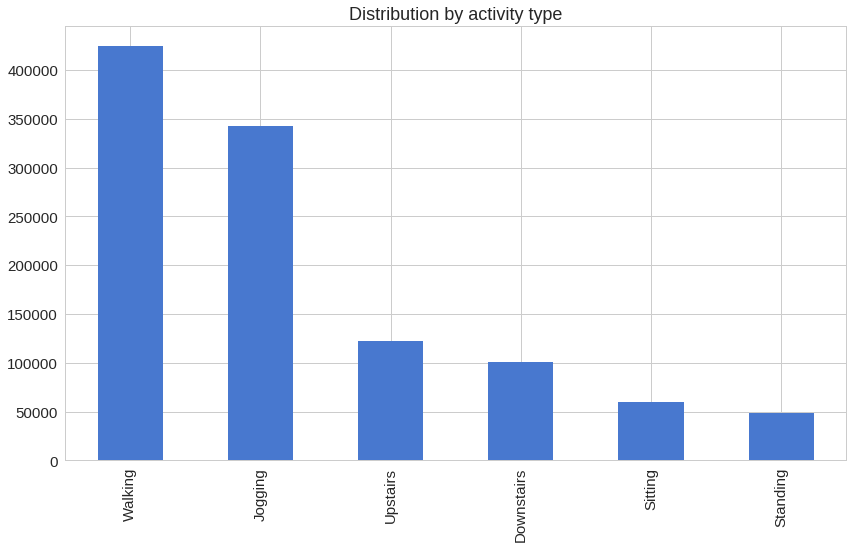

In [7]:
df['activity'].value_counts().plot(kind='bar', title='Distribution by activity type');

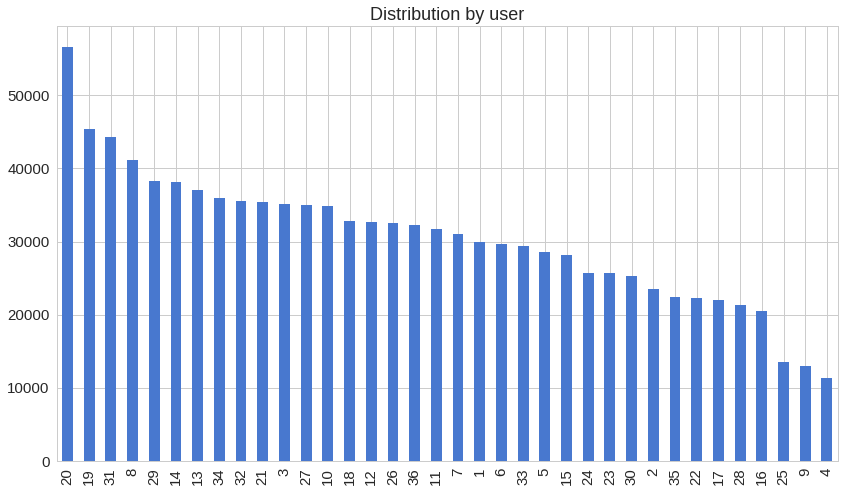

In [8]:
df['user'].value_counts().plot(kind='bar', title='Distribution by user');

In [9]:
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['x-axis', 'y-axis', 'z-axis']][:200]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     ylim=[-3, 3], yticks=range(-3, 4),
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

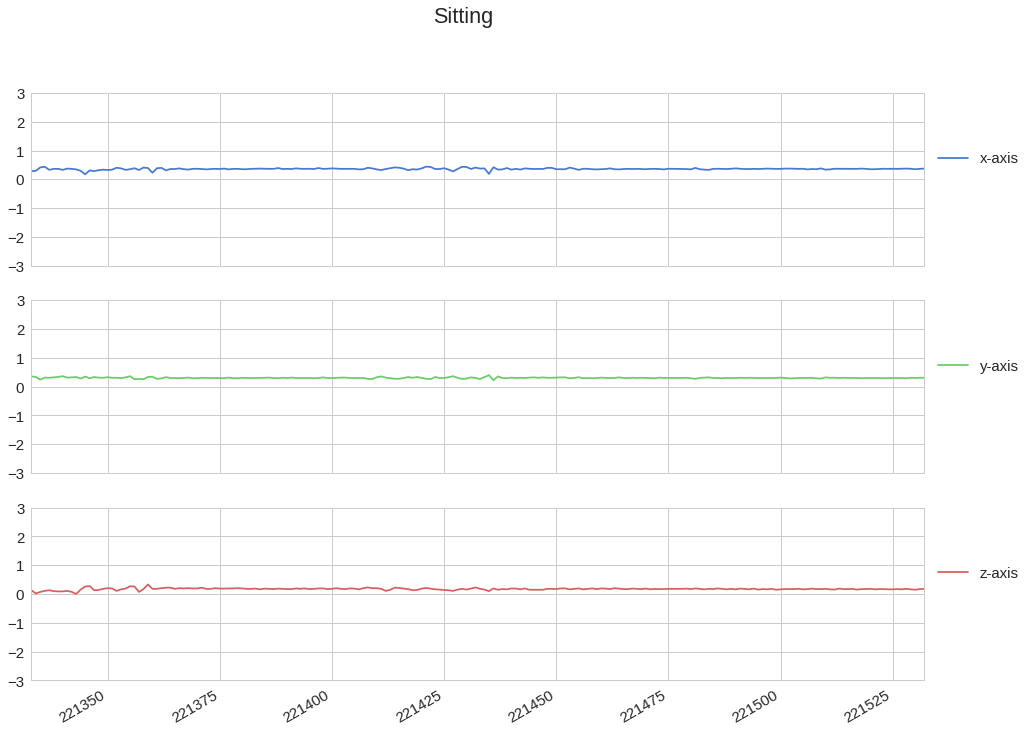

In [10]:
plot_activity("Sitting", df)

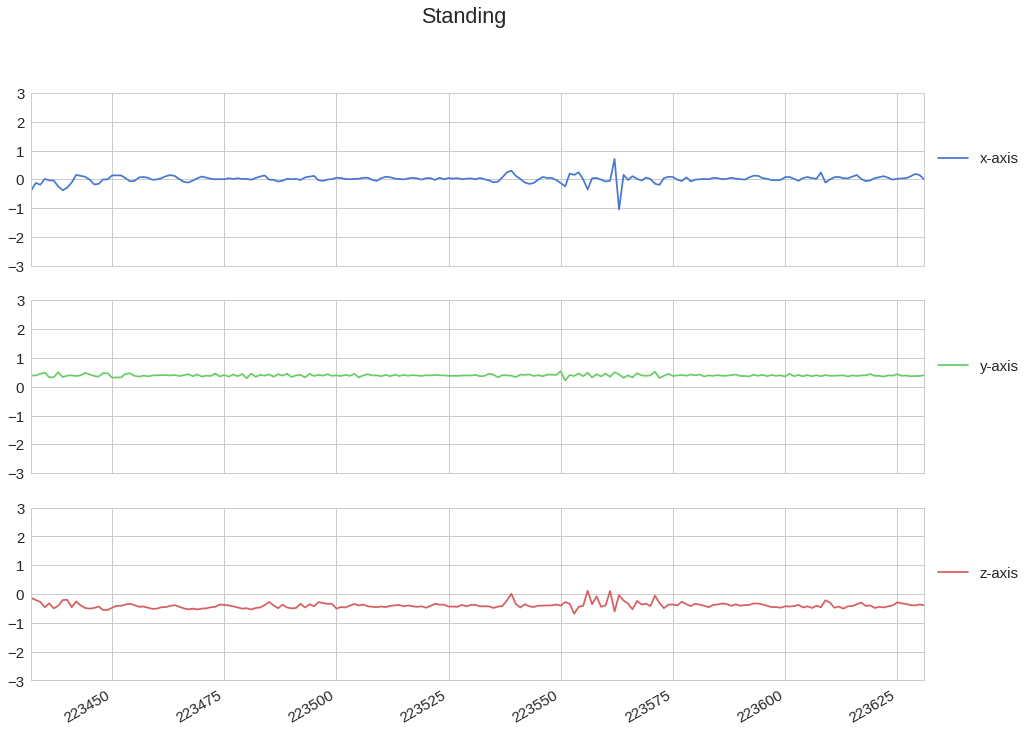

In [11]:
plot_activity("Standing", df)

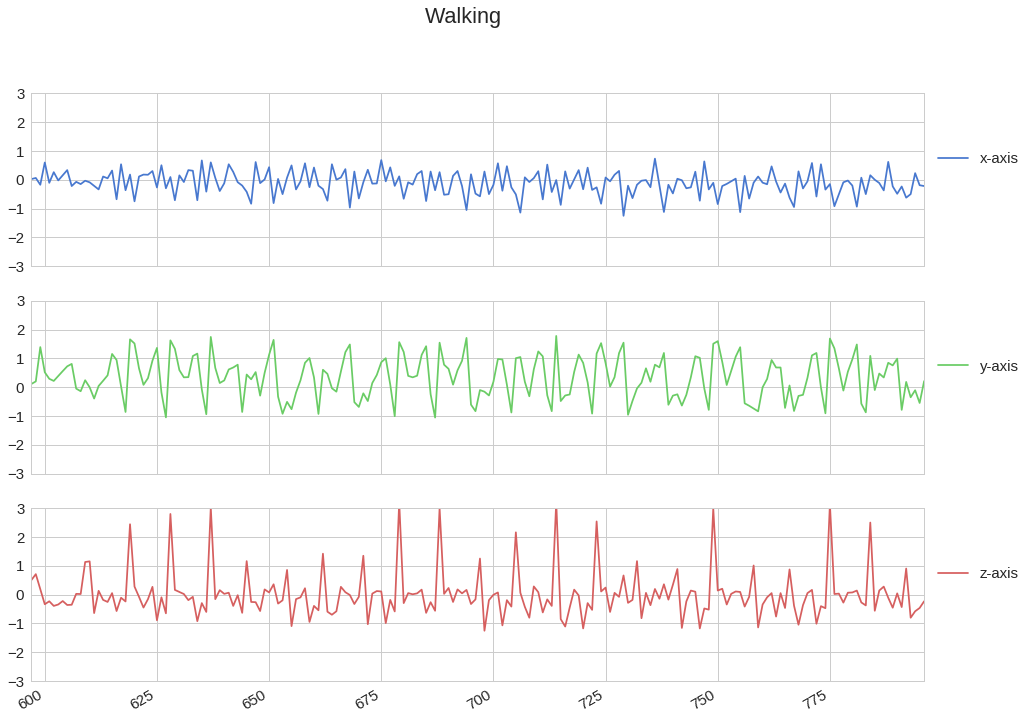

In [12]:
plot_activity("Walking", df)

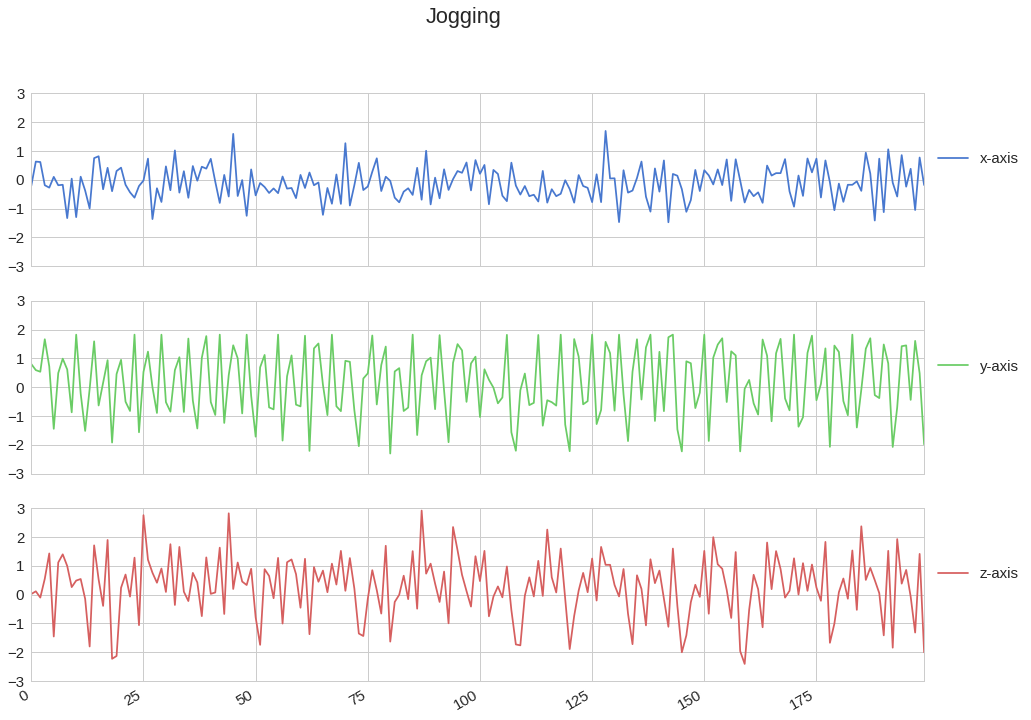

In [13]:
plot_activity("Jogging", df)

In [14]:
step = 10
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['x-axis'].values[i: i + N_TIME_STEPS]
    ys = df['y-axis'].values[i: i + N_TIME_STEPS]
    zs = df['z-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

/home/vini/.pyenv/versions/3.6.1/envs/teaching/lib/python3.6/site-packages/scipy/stats/stats.py:253: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [15]:
np.array(segments).shape

(109801, 3, 200)

In [16]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [17]:
reshaped_segments.shape

(109801, 200, 3)

In [18]:
labels[0]

array([ 0.,  1.,  0.,  0.,  0.,  0.], dtype=float32)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [20]:
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)

    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

In [21]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

# Training

In [22]:
saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(N_EPOCHS):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})


    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    if i % 10 != 0:
        continue

    print(f'epoch: {i} test accuracy: {acc_test} loss: {loss_test}')
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print()
print(f'final results: accuracy: {acc_final} loss: {loss_final}')

pickle.dump(predictions, open("predictions.p", "wb"))
pickle.dump(history, open("history.p", "wb"))
tf.train.write_graph(sess.graph_def, '.', './checkpoint/har.pbtxt')  
saver.save(sess, save_path = "./checkpoint/har.ckpt");

epoch: 0 test accuracy: 0.8054726123809814 loss: 1.1978356838226318
epoch: 10 test accuracy: 0.9729053378105164 loss: 0.3755805790424347
epoch: 20 test accuracy: 0.9755918979644775 loss: 0.26404911279678345
epoch: 30 test accuracy: 0.9731785655021667 loss: 0.2417151778936386
epoch: 40 test accuracy: 0.986247181892395 loss: 0.17441271245479584
epoch: 50 test accuracy: 0.9763205051422119 loss: 0.1903674602508545
epoch: 60 test accuracy: 0.9861105680465698 loss: 0.1586400270462036
epoch: 70 test accuracy: 0.9836516976356506 loss: 0.16093599796295166
epoch: 80 test accuracy: 0.9828776121139526 loss: 0.15954986214637756
epoch: 90 test accuracy: 0.981602668762207 loss: 0.16879835724830627

final results: accuracy: 0.9795535206794739 loss: 0.16460318863391876


In [23]:
history = pickle.load(open("history.p", "rb"))
predictions = pickle.load(open("predictions.p", "rb"))

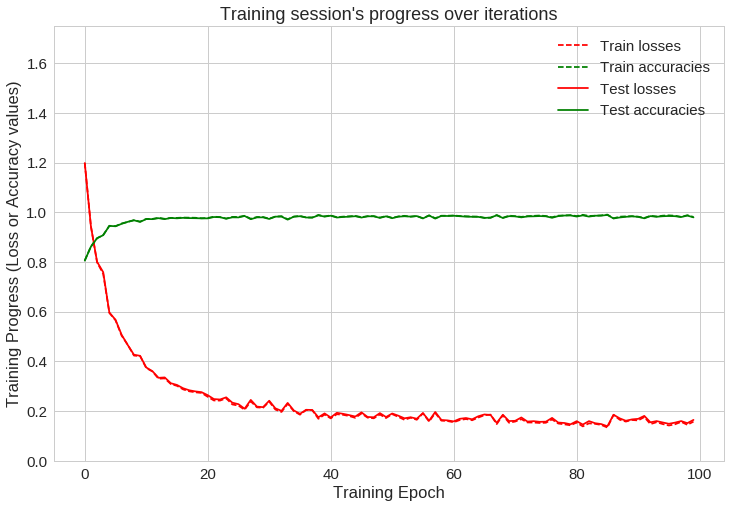

In [24]:
width = 12
height = 8
plt.figure(figsize=(width, height))

plt.plot(np.array(history['train_loss']), "r--", label="Train losses")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracies")

plt.plot(np.array(history['test_loss']), "r-", label="Test losses")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim([0, 1.75])

plt.show()

In [25]:
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32) / np.sum(confusion_matrix)*100

In [26]:
print(confusion_matrix)

[[1885    3    1    1  157   11]
 [   1 6836    0    0   48    7]
 [   1    0 1183    8    3    4]
 [   0    0    2  927    3    2]
 [  41    2    0    1 2370    4]
 [  43    7    0    0   99 8311]]


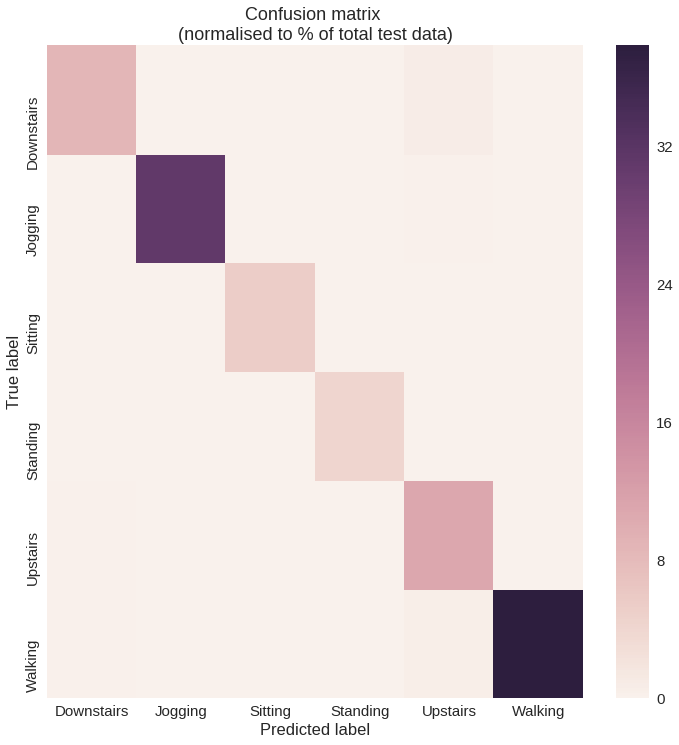

In [27]:
width = 12
height = 12
plt.figure(figsize=(width, height))
sns.heatmap(normalised_confusion_matrix, xticklabels=LABELS, yticklabels=LABELS);
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Freeze the graph (for the Android app)

In [28]:
from tensorflow.python.tools import freeze_graph

MODEL_NAME = 'har'

input_graph_path = 'checkpoint/' + MODEL_NAME+'.pbtxt'
checkpoint_path = './checkpoint/' +MODEL_NAME+'.ckpt'
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
output_frozen_graph_name = 'frozen_'+MODEL_NAME+'.pb'

freeze_graph.freeze_graph(input_graph_path, input_saver="",
                          input_binary=False, input_checkpoint=checkpoint_path, 
                          output_node_names="y_", restore_op_name="save/restore_all",
                          filename_tensor_name="save/Const:0", 
                          output_graph=output_frozen_graph_name, clear_devices=True, initializer_nodes="")

INFO:tensorflow:Restoring parameters from ./checkpoint/har.ckpt
INFO:tensorflow:Froze 8 variables.
Converted 8 variables to const ops.
6850 ops in the final graph.
